## NYC Flight Data Anaysis (2013)

#### Context:
The U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics tracks the on-time performance of domestic flights operated by large air carriers. Summary information on the number of on-time, delayed, canceled, and diverted flights is published in DOT's monthly Air Travel Consumer Report.
The dataset contains information about all flights that departed from NYC (e.g. EWR, JFK and LGA) in 2013: 336,776 flights in total.

This notebook explores few ideas such as:
- Departure delays for every flight.
- Best airports in terms of time departure %
- Aircraft speed analysis
- On time arrival % analysis
- Maximum number of flights headed to a particular destination.

In [1]:
your_local_path="C:/Users/Aswathi/Documents/UPX/Project_Datasets(UPX)/"

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
import seaborn as sns

#### Loading the data:

In [3]:
Flight_Data = pd.read_csv(your_local_path+'flight_data.csv', sep=',', 
                    encoding='UTF-8')
Flight_Data.head(10)
print("Dataframe Dimension : ", Flight_Data.shape)


Dataframe Dimension :  (336776, 19)


#### Checking for null values% in every feature: 

In [4]:
Flight_Data.head(10)
Flight_Data.isnull().sum()
Flight_Data.isnull().sum()/Flight_Data.shape[0]*100
Flight_Data.dtypes
data_info=pd.DataFrame(Flight_Data.dtypes).T.rename(index={0:'Column Type'})
data_info=data_info.append(pd.DataFrame(Flight_Data.isnull().sum()).T.rename(index={0:'Null Values'}))
data_info=data_info.append(pd.DataFrame(Flight_Data.isnull().sum()/Flight_Data.shape[0]*100).T.rename(index={0:'Null Values %'}))
data_info

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
Column Type,int64,int64,int64,float64,int64,float64,float64,int64,float64,object,int64,object,object,object,float64,int64,int64,int64,object
Null Values,0,0,0,8255,0,8255,8713,0,9430,0,0,2512,0,0,9430,0,0,0,0
Null Values %,0,0,0,2.45118,0,2.45118,2.58718,0,2.80008,0,0,0.745896,0,0,2.80008,0,0,0,0


In [5]:
#Creating new feature, Date combining the year, month and day features.

Flight_Data['Date'] = pd.to_datetime(Flight_Data[['year','month', 'day']])
#flight_data = Flight_Data.drop(['year', 'month', 'day'], axis=1)
Flight_Data.head(3)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,Date
0,2013,1,1,517.0,515,2.0,830.0,819,11.0,UA,1545,N14228,EWR,IAH,227.0,1400,5,15,01-01-2013 05:00,2013-01-01
1,2013,1,1,533.0,529,4.0,850.0,830,20.0,UA,1714,N24211,LGA,IAH,227.0,1416,5,29,01-01-2013 05:00,2013-01-01
2,2013,1,1,542.0,540,2.0,923.0,850,33.0,AA,1141,N619AA,JFK,MIA,160.0,1089,5,40,01-01-2013 05:00,2013-01-01


##### Transforming the date time format from 'HHMM' to datetime format for readability.

In [6]:
# Function to convert the 'HHMM' string to datetime.time

def time_format(time):
    if pd.isnull(time):
        return np.nan
    else:
        if time == 2400: time = 0
        time = "{0:04d}".format(int(time))
        hour = datetime.time(int(time[0:2]), int(time[2:4]))
        return hour
    
    
    

In [7]:
Flight_Data['sched_dep_time'] = Flight_Data['sched_dep_time'].apply(time_format)
Flight_Data['dep_time'] = Flight_Data['dep_time'].apply(time_format)
Flight_Data['sched_arr_time'] = Flight_Data['sched_arr_time'].apply(time_format)
Flight_Data['arr_time'] = Flight_Data['arr_time'].apply(time_format)
#__________________________________________________________________________

Flight_Data.loc[:10, ['sched_dep_time', 'dep_time', 'sched_arr_time',
             'arr_time', 'dep_delay', 'arr_delay']]


,sched_dep_time,dep_time,sched_arr_time,arr_time,dep_delay,arr_delay
0,05:15:00,05:17:00,08:19:00,08:30:00,2.0,11.0
1,05:29:00,05:33:00,08:30:00,08:50:00,4.0,20.0
2,05:40:00,05:42:00,08:50:00,09:23:00,2.0,33.0
3,05:45:00,05:44:00,10:22:00,10:04:00,-1.0,-18.0
4,06:00:00,05:54:00,08:37:00,08:12:00,-6.0,-25.0
5,05:58:00,05:54:00,07:28:00,07:40:00,-4.0,12.0
6,06:00:00,05:55:00,08:54:00,09:13:00,-5.0,19.0
7,06:00:00,05:57:00,07:23:00,07:09:00,-3.0,-14.0
8,06:00:00,05:57:00,08:46:00,08:38:00,-3.0,-8.0
9,06:00:00,05:58:00,07:45:00,07:53:00,-2.0,8.0


####  Treating null values :

In [8]:
#FILLING 

fields_to_remove = ['year','month','day','tailnum','time_hour','hour','minute','flight']
Flight_Data.drop(fields_to_remove, axis = 1, inplace = True)
Flight_Data.head(10)
Flight_Data = Flight_Data[['carrier','origin','dest','sched_dep_time','dep_time','dep_delay','sched_arr_time','arr_time','arr_delay','Date','distance','air_time']]
Flight_Data[:5]

,carrier,origin,dest,sched_dep_time,dep_time,dep_delay,sched_arr_time,arr_time,arr_delay,Date,distance,air_time
0,UA,EWR,IAH,05:15:00,05:17:00,2.0,08:19:00,08:30:00,11.0,2013-01-01,1400,227.0
1,UA,LGA,IAH,05:29:00,05:33:00,4.0,08:30:00,08:50:00,20.0,2013-01-01,1416,227.0
2,AA,JFK,MIA,05:40:00,05:42:00,2.0,08:50:00,09:23:00,33.0,2013-01-01,1089,160.0
3,B6,JFK,BQN,05:45:00,05:44:00,-1.0,10:22:00,10:04:00,-18.0,2013-01-01,1576,183.0
4,DL,LGA,ATL,06:00:00,05:54:00,-6.0,08:37:00,08:12:00,-25.0,2013-01-01,762,116.0


In [9]:
missing_df = Flight_Data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['Field', 'Missing Values']

missing_df['Filling Factor %'] = (Flight_Data.shape[0] - missing_df['Missing Values'])/Flight_Data.shape[0]*100
missing_df.sort_values('Filling Factor %').reset_index(drop = True)

,Field,Missing Values,Filling Factor %
0,arr_delay,9430,97.199919
1,air_time,9430,97.199919
2,arr_time,8713,97.412820
3,dep_time,8255,97.548816
4,dep_delay,8255,97.548816
5,carrier,0,100.000000
6,origin,0,100.000000
7,dest,0,100.000000
8,sched_dep_time,0,100.000000
9,sched_arr_time,0,100.000000


In [10]:
Flight_Data.dropna(inplace = True)

### Statistical description of Airlines

In [11]:


# Function to extract statistical parameters from a grouby object:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

Airline_Stats = Flight_Data['dep_delay'].groupby(Flight_Data['carrier']).apply(get_stats).unstack()
Airline_Stats = Airline_Stats.sort_values('count')
Airline_Stats

#Stats of airlines based on arrival delay

Airline_Stats_Arr = Flight_Data['arr_delay'].groupby(Flight_Data['carrier']).apply(get_stats).unstack()
Airline_Stats_Arr = Airline_Stats_Arr.sort_values('count')
Airline_Stats_Arr



,count,max,mean,min
carrier,,,,
OO,29.0,157.0,11.931034,-26.0
HA,342.0,1272.0,-6.915205,-70.0
YV,544.0,381.0,15.556985,-46.0
F9,681.0,834.0,21.920705,-47.0
AS,709.0,198.0,-9.930889,-74.0
FL,3175.0,572.0,20.115906,-44.0
VX,5116.0,676.0,1.764464,-86.0
WN,12044.0,453.0,9.649120,-58.0
9E,17294.0,744.0,7.379669,-68.0


### Percentage of flights departing from NYC per Airline

D:\InstalledFiles\Anaconda3_2018.12\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Unrecognized location 'left center'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


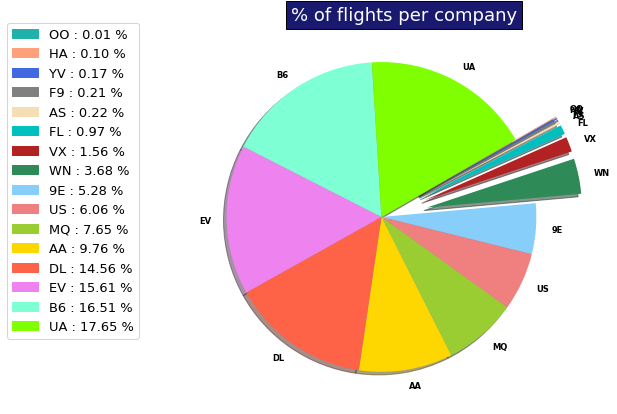

In [12]:


fig = plt.figure(1, figsize=(7,7))

labels = [s for s in  Airline_Stats.index]
sizes = Airline_Stats['count'].values


colors = ['lightseagreen', 'lightsalmon', 'royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
explode = [0.3 if sizes[i] < 13000 else 0.0 for i in range(len(Airline_Stats))]

patches, texts = plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        shadow=True, startangle=30,
        counterclock=False, textprops={"fontweight":"bold", "fontsize":"small"})


# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

percent = 100*sizes/sizes.sum()
per_f = ['{0:1.2f} %'.format(j) for j in percent]

comp_handler = []
for i in range(len(Airline_Stats)):
    comp_handler.append(mpatches.Patch(color=colors[i],
            label = Airline_Stats.index[i]+ ' : '+per_f[i]))
    
plt.legend(handles=comp_handler, loc='left center', bbox_to_anchor=(0, 0.9), 
           fontsize = 13, bbox_transform=plt.gcf().transFigure)

plt.title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)


plt.show()

#### Next we check the departure delays,

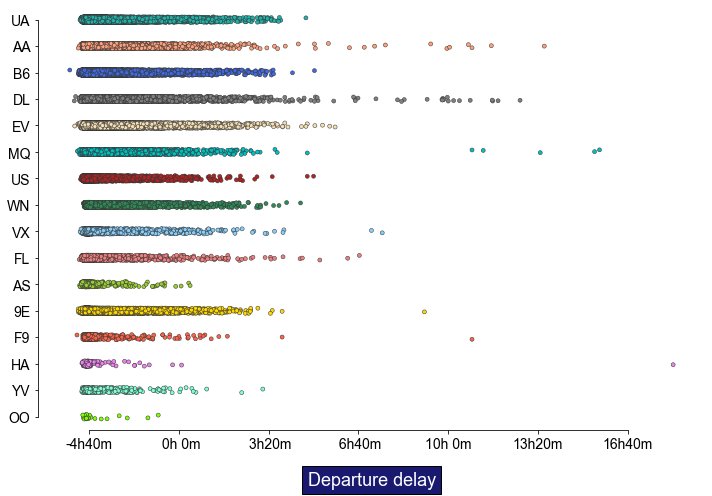

In [13]:
fig = plt.figure(1, figsize=(10,7))

#__________________________________________________________________
# I extract a subset of columns and redefine the airlines labeling 
df2 = Flight_Data.loc[:, ['carrier', 'dep_delay']]

#------------------------------------------------------
# striplot with all the values reported for the delays
#___________________________________________________________________

# I redefine the colors for correspondance with the pie charts
colors = ['lightseagreen', 'lightsalmon', 'royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#___________________________________________________________________

ax0 = sns.stripplot(y="carrier", x="dep_delay", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax0.get_xticklabels(), fontsize=14)
plt.setp(ax0.get_yticklabels(), fontsize=14)
ax0.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax0.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax0.yaxis.label.set_visible(False)
#________________________

sns.set_style("white")
sns.despine(trim=True)
plt.tight_layout(w_pad=3) 
plt.show()

#### Comparison of Mean Departure Delay and Mean Arrival Delay

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


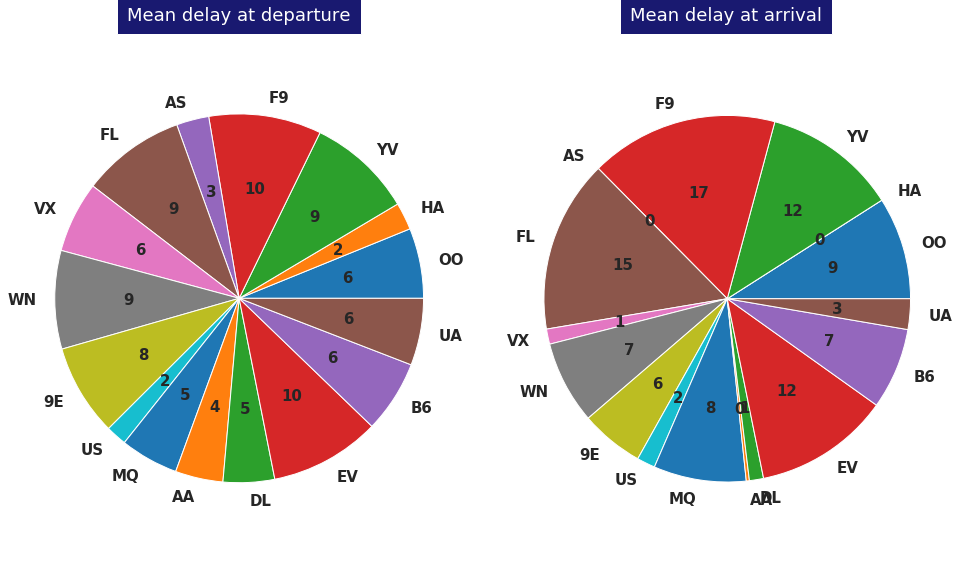

In [14]:
# MEAN DELAY

font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
mpl.rc('font', **font)

#__________________________________________________________________
# Extract a subset of columns and redefine the airlines labeling 

F2 = Flight_Data.loc[:, ['carrier', 'dep_delay']]

fig = plt.figure(1, figsize=(16,10))
gs=GridSpec(1,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 

Stats_d=Flight_Data['dep_delay'].groupby(Flight_Data['carrier']).apply(get_stats).unstack()
Stats_d=Stats_d.sort_values('count')

Stats_a=Flight_Data['arr_delay'].groupby(Flight_Data['carrier']).apply(get_stats).unstack()
Stats_a=Stats_a.sort_values('count')
Stats_a

#----------------------------------------
# Pie chart no.1: mean delay at departure
#----------------------------------------
labels = [s for s in  Stats_d.index]
sizes  = Stats_d['mean'].values
sizes  = [max(s,0) for s in sizes]

#explode = [0.3 if sizes[i] > else 0.0 for i in range(len(Stats_d))]

patches, texts, autotexts = ax1.pie(sizes, labels = labels, shadow=False, startangle=0, 
                                   autopct ='%.0f')

# autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100)

ax1.axis('equal')
ax1.set_title('Mean delay at departure', bbox={'facecolor':'midnightblue', 'pad':10},
              color='w', fontsize=18)

#----------------------------------------
# Pie chart no. 2: mean delay at arrival
#----------------------------------------
labels = [s for s in  Stats_a.index]
sizes  = Stats_a['mean'].values
sizes  = [max(s,0) for s in sizes]
#explode = [0.8 if sizes[i] < 3 else 0.01 for i in range(len(Stats_a))]

patches, texts, autotexts = ax2.pie(sizes, labels = labels, shadow=False, startangle=0,
                                     autopct ='%.0f')

    
ax2.axis('equal')
ax2.set_title('Mean delay at arrival', bbox={'facecolor':'midnightblue', 'pad':10},
              color='w', fontsize=18)
plt.show()



In [15]:
#ARRIVAL AND DEPARTURE DELAYS

Avg_Arr_Delay = pd.DataFrame({'Avg_Arrival_Delay' : Flight_Data.groupby(['carrier'])['arr_delay'].mean()}).reset_index()
Avg_Dep_Delay = pd.DataFrame({'Avg_Departure_Delay' : Flight_Data.groupby(['carrier'])['dep_delay'].mean()}).reset_index()

Avg_Delays = pd.merge( Avg_Arr_Delay, Avg_Dep_Delay, left_on='carrier', right_on='carrier', how='left')

Avg_Delays

,carrier,Avg_Arrival_Delay,Avg_Departure_Delay
0,9E,7.379669,16.439574
1,AA,0.364291,8.569130
2,AS,-9.930889,5.830748
3,B6,9.457973,12.967548
4,DL,1.644341,9.223950
5,EV,15.796431,19.838929
6,F9,21.920705,20.201175
7,FL,20.115906,18.605984
8,HA,-6.915205,4.900585
9,MQ,10.774733,10.445381


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


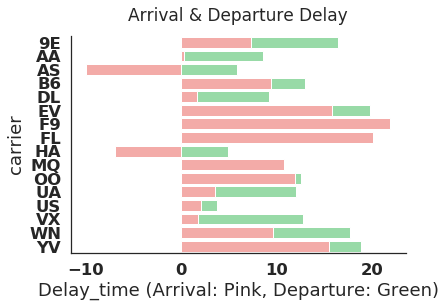

In [16]:
ax = sns.set_color_codes("pastel")
sns.set_context("notebook", font_scale=1.5)
ax = sns.barplot(x="Avg_Departure_Delay", y="carrier", data=Avg_Dep_Delay,
            label="accuracy", color="g")
ax = sns.barplot(x="Avg_Arrival_Delay", y="carrier", data=Avg_Arr_Delay,
            label="accuracy", color="r")
ax.set(xlabel="Delay_time (Arrival: Pink, Departure: Green)")

sns.set_style("white")
sns.despine(trim=False)

ttl = ax.set_title('Arrival & Departure Delay', fontsize=17)
ttl.set_position([.5, 1.04])

plt.show()

### How punctual are the airlines in terms of departure % ?

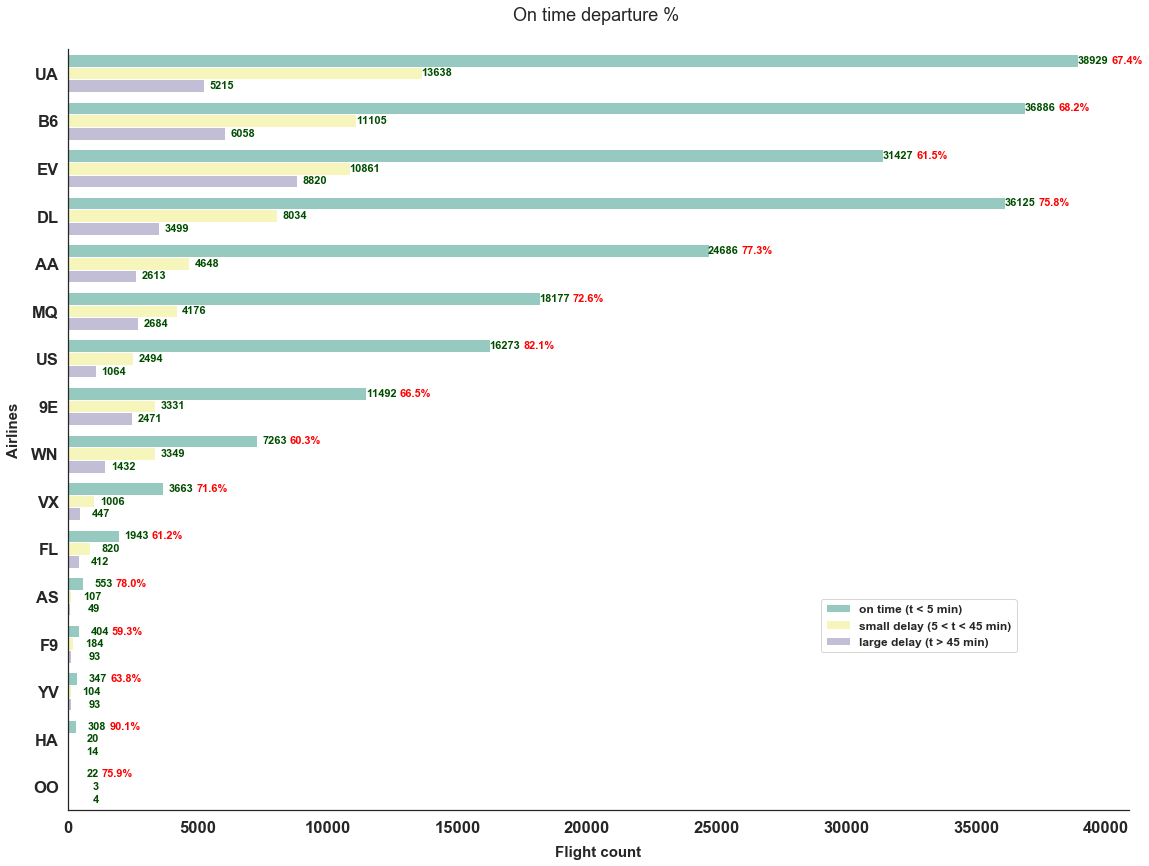

In [17]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
Flight_Data['Delay_Level'] = Flight_Data['dep_delay'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(19,14))

ax = sns.countplot(y="carrier", hue='Delay_Level', data=Flight_Data, palette = 'Set3', order=['UA', 'B6', 'EV', 'DL', 'AA', 'MQ', 'US', '9E', 'WN', 'VX', 'FL', 'AS',
       'F9', 'YV', 'HA', 'OO'])

plt.xlabel('Flight count', fontsize=15, weight = 'bold', labelpad=10)
plt.ylabel('Airlines', fontsize=15, weight = 'bold', labelpad=10)

ncount = Airline_Stats.loc[:,['count']].copy()
total = ncount.sort_values(by=['count'], ascending=False)

for p in ax.patches:
    ax.annotate(str(int(p.get_width())),((p.get_x() + p.get_width()), p.get_y()), xytext=(30, -9),fontsize=11,color='#004d00',textcoords='offset points', horizontalalignment='right')

for p, l in zip(ax.patches, total['count']):
    ax.annotate('{:.1f}%'.format(100.*(p.get_width())/l),((p.get_x() + p.get_width()), p.get_y()), xytext=(33, -9),fontsize=11,color='red',textcoords='offset points', horizontalalignment='left')

# set the alignment of the text
    
    
#________________
# Set the legend
L = plt.legend(loc='lower right', bbox_to_anchor=(0.9, 0.2), fontsize = 12)
#(loc='left', bbox_to_anchor=(0, 0), fontsize = 13, bbox_transform=plt.gcf().transFigure)
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')

sns.set_style("white")
sns.despine(trim=False)

ttl = ax.set_title('On time departure % ', fontsize=18)
ttl.set_position([.5, 1.03])

plt.show()
#____________________________________________________________________________________


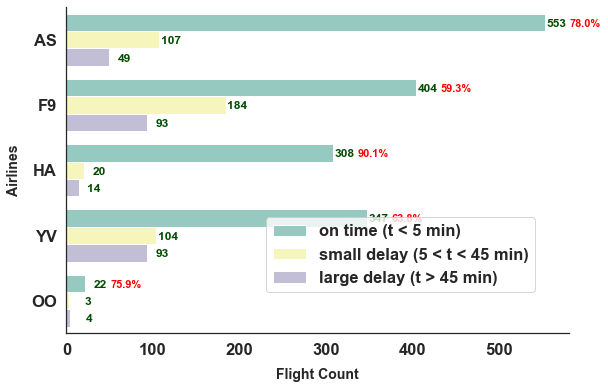

In [18]:
#names = ['WN','VX','FL','AS','9E','F9','HA','YV','OO']
names = ['AS','F9','HA','YV','OO']
#names = ['OO']
Subset_Data = Flight_Data.loc[Flight_Data['carrier'].isin(names)].reset_index(drop=True)

#____________________________________________________
fig = plt.figure(1, figsize=(9,6))

ax = sns.countplot(y="carrier", hue='Delay_Level', data=Subset_Data, palette='Set3')

plt.xlabel('Flight Count', fontsize=14, weight = 'bold', labelpad=10)
plt.ylabel('Airlines', fontsize=14, weight = 'bold', labelpad=10)

s_total = total.loc[['AS','F9','HA','YV','OO'],:]

for p in ax.patches: 
    ax.annotate(str(int(p.get_width())),((p.get_x() + p.get_width()), p.get_y()), xytext=(22, -13), color='#004d00',fontsize = 12,textcoords='offset points', horizontalalignment='right')

for p, l in zip(ax.patches, s_total['count']):
    ax.annotate('{:.1f}%'.format(100.*(p.get_width())/l),((p.get_x() + p.get_width()), p.get_y()), xytext=(25, -13),fontsize=11,color='red',textcoords='offset points', horizontalalignment='left')

    
    

#________________
# Set the legend
L = plt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.1))
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')

sns.set_style("white")
sns.despine(trim=False)
#____________________________________________________________________________________
plt.show()




### Comparing the airlines on the basis of on-time Arrival % 

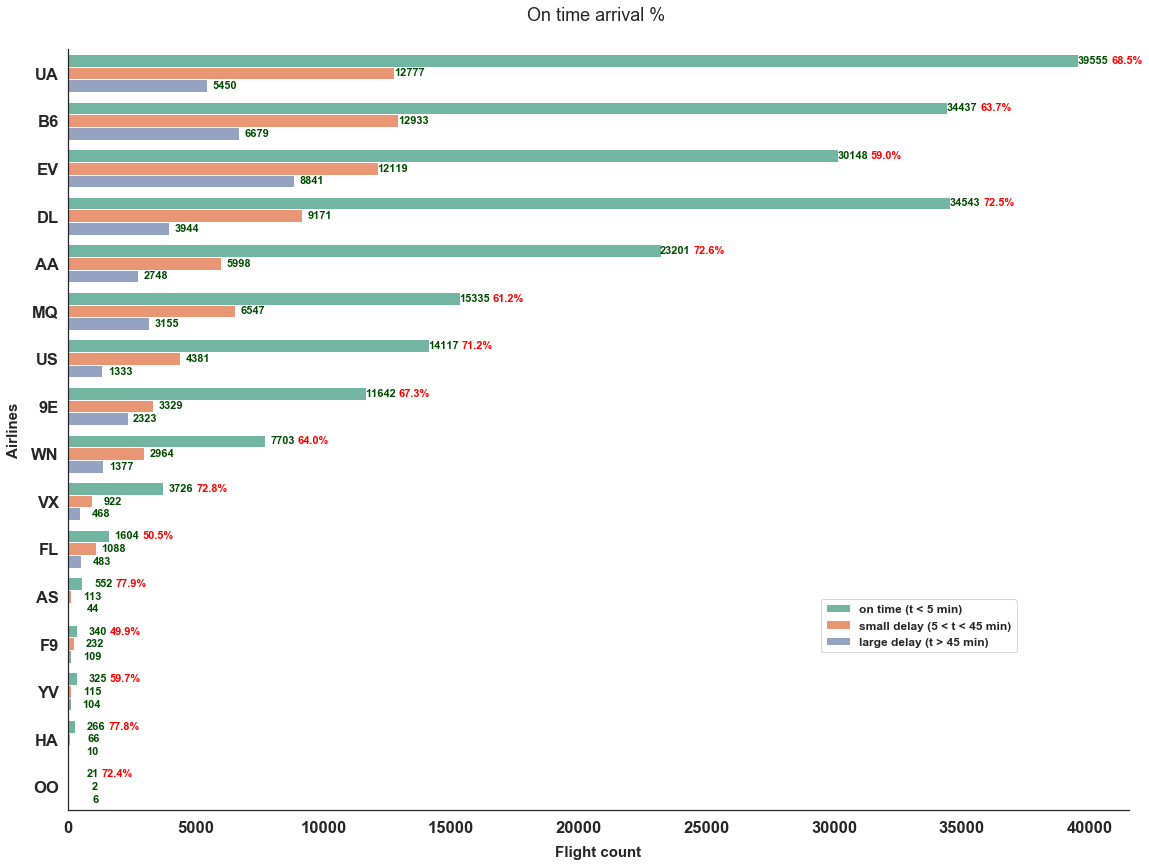

In [19]:
#Best airports in terms of on time arrival %

#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
Flight_Data['Arr_Delay_Level'] = Flight_Data['arr_delay'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(19,14))

ax = sns.countplot(y="carrier", hue='Arr_Delay_Level', data=Flight_Data, palette = 'Set2', order=['UA', 'B6', 'EV', 'DL', 'AA', 'MQ', 'US', '9E', 'WN', 'VX', 'FL', 'AS',
       'F9', 'YV', 'HA', 'OO'])

plt.xlabel('Flight count', fontsize=15, weight = 'bold', labelpad=10)
plt.ylabel('Airlines', fontsize=15, weight = 'bold', labelpad=10)

ncount = Airline_Stats.loc[:,['count']].copy()
total = ncount.sort_values(by=['count'], ascending=False)

for p in ax.patches:
    ax.annotate(str(int(p.get_width())),((p.get_x() + p.get_width()), p.get_y()), xytext=(30, -9),fontsize=11,color='#004d00',textcoords='offset points', horizontalalignment='right')

for p, l in zip(ax.patches, total['count']):
    ax.annotate('{:.1f}%'.format(100.*(p.get_width())/l),((p.get_x() + p.get_width()), p.get_y()), xytext=(33, -9),fontsize=11,color='red',textcoords='offset points', horizontalalignment='left')

# set the alignment of the text
    
    
#________________
# Set the legend
L = plt.legend(loc='lower right', bbox_to_anchor=(0.9, 0.2), fontsize = 12)
#(loc='left', bbox_to_anchor=(0, 0), fontsize = 13, bbox_transform=plt.gcf().transFigure)
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')

sns.set_style("white")
sns.despine(trim=False)

ttl = ax.set_title('On time arrival % ', fontsize=18)
ttl.set_position([.5, 1.03])

plt.show()
#____________________________________________________________________________________


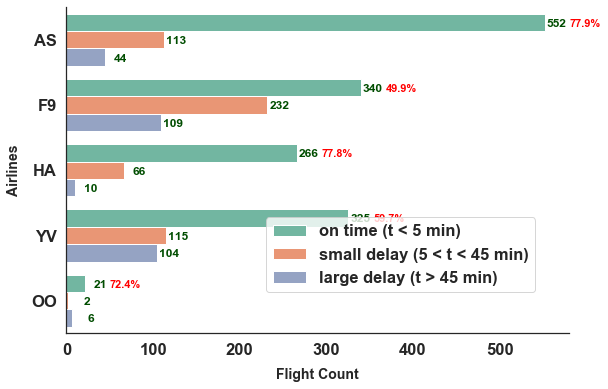

In [20]:
#names = ['WN','VX','FL','AS','9E','F9','HA','YV','OO']
names = ['AS','F9','HA','YV','OO']
#names = ['OO']
Subset_Data = Flight_Data.loc[Flight_Data['carrier'].isin(names)].reset_index(drop=True)

#____________________________________________________
fig = plt.figure(1, figsize=(9,6))

ax = sns.countplot(y="carrier", hue='Arr_Delay_Level', data=Subset_Data, palette='Set2')

plt.xlabel('Flight Count', fontsize=14, weight = 'bold', labelpad=10)
plt.ylabel('Airlines', fontsize=14, weight = 'bold', labelpad=10)

s_total = total.loc[['AS','F9','HA','YV','OO'],:]

for p in ax.patches: 
    ax.annotate(str(int(p.get_width())),((p.get_x() + p.get_width()), p.get_y()), xytext=(22, -13), color='#004d00',fontsize = 12,textcoords='offset points', horizontalalignment='right')

for p, l in zip(ax.patches, s_total['count']):
    ax.annotate('{:.1f}%'.format(100.*(p.get_width())/l),((p.get_x() + p.get_width()), p.get_y()), xytext=(25, -13),fontsize=11,color='red',textcoords='offset points', horizontalalignment='left')

    
    

#________________
# Set the legend
L = plt.legend(loc='lower right', bbox_to_anchor=(0.95, 0.1))
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')

sns.set_style("white")
sns.despine(trim=False)
#____________________________________________________________________________________
plt.show()




### Mean Departure Delay from EWR, LGA, JFK airports.

In [21]:
Airports_MeanDD = pd.DataFrame(pd.Series(Flight_Data['origin'].unique()))
Airports_MeanDD.set_index(0, drop = True, inplace = True)

Carriers = Flight_Data['carrier'].unique()

for carrier in Carriers:
    filter_carrier = Flight_Data[Flight_Data['carrier'] == carrier]

    carrier_delay = filter_carrier['dep_delay'].groupby(Flight_Data['origin']).apply(get_stats).unstack()
    Airports_MeanDD[carrier] = carrier_delay.loc[:, 'mean'] 
   
Airports_MeanDD


,UA,AA,B6,DL,EV,MQ,US,WN,VX,FL,AS,9E,F9,HA,YV,OO
0,,,,,,,,,,,,,,,,
EWR,12.429859,9.985430,13.009271,12.055879,20.049522,17.312351,3.699723,17.799703,11.942655,NaN,5.830748,5.656329,NaN,NaN,NaN,20.833333
LGA,12.022427,6.701882,14.728642,9.533678,18.987477,8.435163,3.258991,17.522044,NaN,18.605984,NaN,8.709623,20.201175,NaN,18.898897,10.434783
JFK,7.811300,10.276176,12.711227,8.288779,18.520362,13.073121,5.865385,NaN,13.111111,NaN,NaN,18.702663,NaN,4.900585,NaN,NaN


### Mean Arrival Delay in arriving at EWR, LGA, JFK airports.

In [22]:
Airports_MeanAD = pd.DataFrame(pd.Series(Flight_Data['origin'].unique()))
Airports_MeanAD.set_index(0, drop = True, inplace = True)

Carriers = Flight_Data['carrier'].unique()

for carrier in Carriers:
    filter_carrier = Flight_Data[Flight_Data['carrier'] == carrier]

    carrier_delay = filter_carrier['arr_delay'].groupby(Flight_Data['origin']).apply(get_stats).unstack()
    Airports_MeanAD[carrier] = carrier_delay.loc[:, 'mean'] 
    
Airports_MeanAD

,UA,AA,B6,DL,EV,MQ,US,WN,VX,FL,AS,9E,F9,HA,YV,OO
0,,,,,,,,,,,,,,,,
EWR,3.475176,0.977698,9.388597,8.780442,17.022620,16.307105,0.977115,11.063243,-0.677191,NaN,-9.930889,1.615256,NaN,NaN,NaN,21.500000
LGA,4.642189,-1.331754,13.511419,3.927776,9.279878,9.334865,2.530819,8.218938,NaN,20.115906,NaN,1.768546,21.920705,NaN,15.556985,9.434783
JFK,2.510496,2.081250,8.893702,-2.379250,17.788839,12.468704,2.114035,NaN,2.827722,NaN,NaN,8.843327,NaN,-6.915205,NaN,NaN


### Scale of delays to and from origin airport

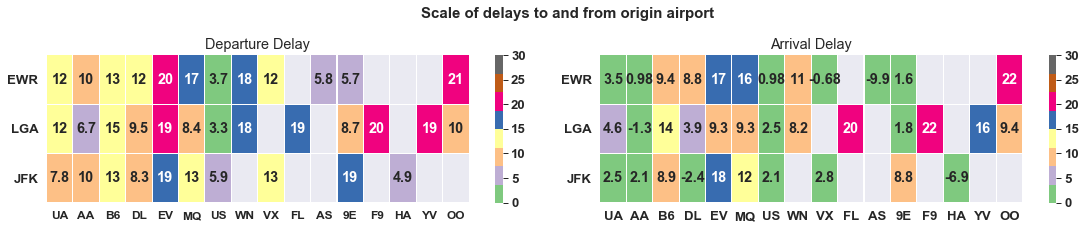

In [23]:
sns.set(context="paper", font_scale=1.5)
fig = plt.figure(1, figsize=(16,3))

mask = Airports_MeanDD.isnull()

ax = fig.add_subplot(1,2,1)
ax = sns.heatmap(Airports_MeanDD, linewidths=0.04, cmap="Accent", mask=mask, vmin = 0, vmax = 30, annot = True)
plt.setp(ax.get_xticklabels(), fontsize=12, rotation = 88) ;

ax.yaxis.label.set_visible(False)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('Departure Delay')
fig.text(0.5, 1.02, "Scale of delays to and from origin airport", ha='center', fontsize = 15)

ax = fig.add_subplot(1,2,2)  

ax = sns.heatmap(Airports_MeanAD, linewidths=0.04, cmap="Accent", mask=mask, vmin = 0, vmax = 30, annot = True)


ax.yaxis.label.set_visible(False)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.title('Arrival Delay')


plt.tight_layout()
plt.show()

### Mean departure and arrival delays with respect to airports.

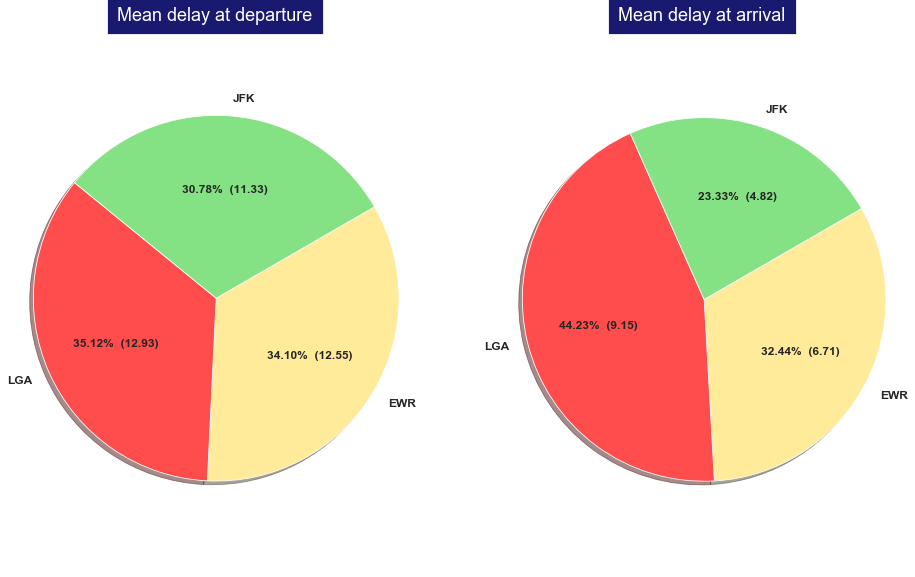

In [24]:
Airports_Total_MeanDD = Airports_MeanDD.mean(axis=1)
Airports_Total_MeanDD = pd.DataFrame(data = Airports_Total_MeanDD)
Airports_Total_MeanDD.columns = ['Mean_Dep_Delay']

fig = plt.figure(1, figsize=(16,10))
gs=GridSpec(1,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 

labels = [s for s in  Airports_Total_MeanDD.index]
sizes = Airports_Total_MeanDD['Mean_Dep_Delay']


#colors = ['#ff9999', '#ff4d4d','#ffe6e6']
colors = [ '#ffeb99','#ff4d4d','#84e184']
#84e184
def make_autopct(sizes):
    def my_autopct(pct):
        total = sum(sizes)
        val = pct*total/100.0
        return '{p:.2f}%  ({v:.2f})'.format(p=pct,v=val)
    return my_autopct


ax1.pie(sizes, labels=labels, colors=colors,
        shadow=True, startangle=30, autopct=make_autopct(sizes),
        counterclock=False, textprops={"fontweight":"bold", "fontsize":"small"})


# Set aspect ratio to be equal so that pie is drawn as a circle.
ax1.axis('equal')

ax1.set_title('Mean delay at departure', bbox={'facecolor':'midnightblue', 'pad':10},
              color='w', fontsize=18)


Airports_Total_MeanAD = Airports_MeanAD.mean(axis=1)
Airports_Total_MeanAD = pd.DataFrame(data = Airports_Total_MeanAD)
Airports_Total_MeanAD.columns = ['Mean_Arr_Delay']

labels = [s for s in  Airports_Total_MeanAD.index]
sizes = Airports_Total_MeanAD['Mean_Arr_Delay']


colors = [ '#ffeb99','#ff4d4d','#84e184']


def make_autopct(sizes):
    def my_autopct(pct):
        total = sum(sizes)
        val = pct*total/100.0
        return '{p:.2f}%  ({v:.2f})'.format(p=pct,v=val)
    return my_autopct


ax2.pie(sizes, labels=labels, colors=colors,
        shadow=True, startangle=30, autopct=make_autopct(sizes),
        counterclock=False, textprops={"fontweight":"bold", "fontsize":"small"})


# Set aspect ratio to be equal so that pie is drawn as a circle.
ax2.axis('equal')

ax2.set_title('Mean delay at arrival', bbox={'facecolor':'midnightblue', 'pad':10},
              color='w', fontsize=18)

plt.show()




#font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 15}
#mpl.rc('font', **font)  





### Aircraft Speed Analysis

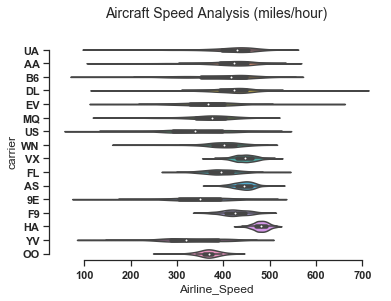

In [25]:
Flight_Data['Airline_Speed'] = 60*Flight_Data['distance']/Flight_Data['air_time']
sns.set_context("notebook", font_scale=2.5)
sns.set(style="ticks", palette="muted", color_codes=True)
ax = sns.violinplot(x="Airline_Speed", y="carrier", data=Flight_Data);

ttl = ax.set_title('Aircraft Speed Analysis (miles/hour)', fontsize=14)
ttl.set_position([.5, 1.09])

sns.despine(trim=True)
plt.show()